# Deep Learning with Transfer Learning 
## Detecting Cracks in Concrete
### NAME: ANANYA CHAKRAVARTHI
### LINKEDIN: https://www.linkedin.com/in/ananya-chakravarthi/

In [1]:
# importing all necessary packages

import os
import os.path as op
import json
from pathlib import Path
import shutil
import logging
import numpy as np
from tqdm import tqdm
from skimage import io
!pip install tensorflow
!pip3 install --upgrade pip
!pip install opencv-python


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 14.5 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: pip
    Found existing installation: pip 23.3.1
    Uninstalling pip-23.3.1:
      Successfully uninstalled pip-23.3.1


In [62]:
# Logging configuration
logging.basicConfig(level=logging.INFO,
                    datefmt='%H:%M:%S',
                    format='%(asctime)s | %(levelname)-5s | %(module)-15s | %(message)s')

IMAGE_SIZE = (256, 256)  # All images contained in this dataset are 299x299 (originally, to match Inception v3 input size)
SEED = 17

# Head directory containing all image subframes. Update with the relative path of your data directory
data_head_dir = Path('./archive/Pavements')


# Loading and Preprocessing Data

In [61]:
import random
import tensorflow as tf
from PIL import Image 

def load_and_preprocess(img_loc, label):
    def _inner_function(img_loc, label):
        # Convert tensor to native type
        img_loc_str = img_loc.numpy().decode('utf-8')

        # Load image using PIL and convert to RGB
        img = Image.open(img_loc_str).convert('RGB')
        
        # Convert PIL image to numpy array
        img = np.array(img)
        img = tf.image.resize(img, [256, 256])



        # Convert label to integer (assuming binary classification)
        label = 1 if label.numpy().decode('utf-8') == 'Cracked' else 0
         
        return img, label

    # Wrap the Python function
    X, y = tf.py_function(_inner_function, [img_loc, label], [tf.float32, tf.int64])

    # Set the shape of the tensors
    X.set_shape([256, 256, 3])
    y.set_shape([]) 

    return X, y


def load_subdir_data(dir_path, image_size, seed=None):
    
    """Helper to create a TF dataset from each image subdirectory"""
    
    # Grab only the classes that (1) we want to keep and (2) exist in this directory
    
    
    loc_list = []
    
    for folder in os.listdir(dir_path):
        if os.path.isdir(os.path.join(dir_path, folder)):
            for file in os.listdir(os.path.join(dir_path, folder)):
                if file.endswith(".jpg"):
                    loc_list.append((os.path.join(os.path.join(dir_path, folder), file), folder))
    return loc_list

# Loop over all subframes, loading each into a list
tf_data = []
tf_dataset = []

tf_data.extend(load_subdir_data(data_head_dir, IMAGE_SIZE, SEED))

# Update the batch and buffer size as per your model requirements
buffer_size = 64
batch_size = 32


# Data Balancing

In [42]:
random.shuffle(tf_data)
tf_data

non_cracked = list(filter(lambda x:x[1] == 'Non-cracked', tf_data))
cracked = list(filter(lambda x:x[1] == 'Cracked', tf_data))


print('Before Balancing:')
print(len(cracked), len(non_cracked))
tf_data_balanced = []
for i in range(10000):
    tf_data_balanced.append(non_cracked[random.randint(0, len(non_cracked)-1)])
    tf_data_balanced.append(cracked[random.randint(0, len(cracked)-1)])
    
random.shuffle(tf_data_balanced)

non_cracked = list(filter(lambda x:x[1] == 'Non-cracked', tf_data_balanced))
cracked = list(filter(lambda x:x[1] == 'Cracked', tf_data_balanced))
print('After Balancing:')
print(len(cracked), len(non_cracked))

Before Balancing:
2608 21726
After Balancing:
10000 10000


In [45]:
from sklearn.model_selection import train_test_split

tf_data_train, tf_data_test = train_test_split(tf_data_balanced, test_size=0.2, random_state=1)

tf_data_train, tf_data_val = train_test_split(tf_data_train, test_size=0.25, random_state=1)

In [46]:
random.shuffle(tf_data_train)
img_list, label_list = zip(*tf_data_train)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_train = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_train = tf_dataset_train.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_train = tf_dataset_train.shuffle(buffer_size=buffer_size).batch(batch_size) 

random.shuffle(tf_data_val)
img_list, label_list = zip(*tf_data_val)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_val = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_val = tf_dataset_val.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_val = tf_dataset_val.shuffle(buffer_size=buffer_size).batch(batch_size) 

random.shuffle(tf_data_test)
img_list, label_list = zip(*tf_data_test)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_test = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_test = tf_dataset_test.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_test = tf_dataset_test.shuffle(buffer_size=buffer_size).batch(batch_size) 
 

# Transfer Learning 

In [44]:
print(tf_dataset_train.element_spec)
print(tf_dataset_val.element_spec)

(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))
(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))


In [55]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0, ResNet50, VGG16

base_model = EfficientNetB0(weights='imagenet', include_top=False)

base_model.trainable = False
final_layer = models.Sequential([
    layers.Dense(512),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(2, activation='softmax')
])

inputs = tf.keras.Input(shape=(256,256,3))
data_augmentation = tf.keras.Sequential([
tf.keras.layers.RandomFlip('horizontal_and_vertical'),
tf.keras.layers.RandomTranslation(0.2, 0.2),
tf.keras.layers.RandomRotation(0.2),
tf.keras.layers.RandomBrightness(factor=0.2),
tf.keras.layers.RandomContrast(0.5),
tf.keras.layers.RandomCrop(200, 200),
tf.keras.layers.RandomZoom(0.3),
])

x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
x = final_layer(x)

efficientnet_model = tf.keras.Model(inputs, x)
efficientnet_model.summary()

efficientnet_model.compile(optimizer='Adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential_13 (Sequential)  (None, 200, 200, 3)       0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling2d_2  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_17 (Dropout)        (None, 1280)              0         
                                                                 
 sequential_12 (Sequential)  (None, 2)                 6589

Epoch 1/20
375/375 [==============================] - 327s 862ms/step - loss: 0.7224 - accuracy: 0.6848 - val_loss: 0.3890 - val_accuracy: 0.8307
Epoch 2/20
375/375 [==============================] - 334s 892ms/step - loss: 0.5508 - accuracy: 0.7151 - val_loss: 0.4150 - val_accuracy: 0.8305
Epoch 3/20
125/125 [==============================] - 81s 645ms/step - loss: 0.3911 - accuracy: 0.8315
Test Accuracy: 0.8314999938011169


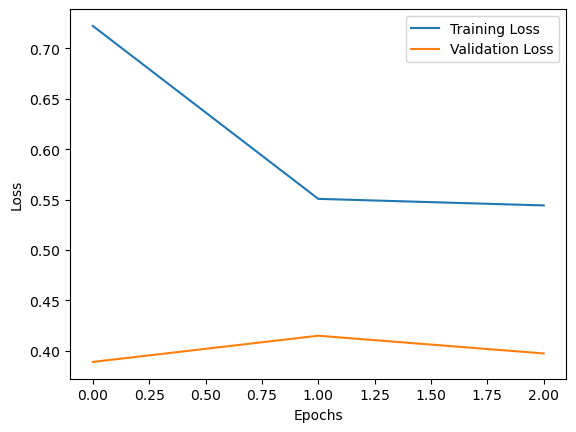

In [56]:
NUM_EPOCHS = 20

#Performing early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

history = efficientnet_model.fit(tf_dataset_train, epochs=NUM_EPOCHS,
                    validation_data=tf_dataset_val, callbacks=[early_stopping])

test_loss, test_acc = efficientnet_model.evaluate(tf_dataset_test)
print(f'Test Accuracy: {test_acc}')

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [59]:
true_labels = []
binary_predictions = []
threshold = 0.5

for value, label in tf_dataset_test:
    predictions = efficientnet_model.predict(value)
    binary_predictions.extend([0 if e[0] > e[1] else 1 for e in predictions])
    true_labels.extend([e for e in label])

true_labels = np.array(true_labels)
binary_predictions = np.array(binary_predictions)

true_labels = true_labels.flatten()
binary_predictions = binary_predictions.flatten()

print(true_labels.shape)
print(binary_predictions.shape)

1/1 [==============================] - 1s 624ms/step
(4000,)
(4000,)


In [60]:
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix

precision = precision_score(true_labels, binary_predictions, average='weighted')
recall = recall_score(true_labels, binary_predictions, average='weighted')
f1 = f1_score(true_labels, binary_predictions, average='weighted')
accuracy = accuracy_score(true_labels, binary_predictions)

print('EfficientNetB0 Model')
print(classification_report(true_labels, binary_predictions))
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

EfficientNetB0 Model
              precision    recall  f1-score   support

           0       0.81      0.87      0.83      1969
           1       0.86      0.80      0.83      2031

    accuracy                           0.83      4000
   macro avg       0.83      0.83      0.83      4000
weighted avg       0.83      0.83      0.83      4000

Accuracy: 0.8315
Precision: 0.8334
Recall: 0.8315
F1 Score: 0.8314


### We find that test F1-score is 0.8314. 